In [1]:
import arcpy
from arcpy import env
import os
import numpy as np
from arcgis import GIS
from arcgis.features import GeoAccessor
from arcgis.features import GeoSeriesAccessor
import pandas as pd

arcpy.env.overwriteOutput = True
arcpy.env.parallelProcessingFactor = "90%"

# show all columns
pd.options.display.max_columns = None

# pd.pivot_table(df, values='a', index='b', columns='c', aggfunc='sum', fill_value=0)
# pd.DataFrame.spatial.from_featureclass(???)  
# df.spatial.to_featureclass(location=???,sanitize_columns=False)  

# gsa = arcgis.features.GeoSeriesAccessor(df['SHAPE'])  
# df['AREA'] = gsa.area  # KNOW YOUR UNITS

In [2]:
# fill NA values in Spatially enabled dataframes (ignores SHAPE column)
def fill_na_sedf(df_with_shape_column, fill_value=0):
    if 'SHAPE' in list(df_with_shape_column.columns):
        df = df_with_shape_column.copy()
        shape_column = df['SHAPE'].copy()
        del df['SHAPE']
        return df.fillna(fill_value).merge(shape_column,left_index=True, right_index=True, how='inner')
    else:
        raise Exception("Dataframe does not include 'SHAPE' column")

In [3]:
outputs = ['.\\Outputs', "scratch2.gdb", 'results.gdb']

if not os.path.exists(outputs[0]):
    os.makedirs(outputs[0])

gdb = os.path.join(outputs[0], outputs[1])
gdb2 = os.path.join(outputs[0], outputs[2])

if not arcpy.Exists(gdb):
    arcpy.CreateFileGDB_management(outputs[0], outputs[1])

if not arcpy.Exists(gdb2):
    arcpy.CreateFileGDB_management(outputs[0], outputs[2])

In [4]:
lanes = r'E:\Projects\Bike-App-Create-Features\Inputs\Lanes.shp'
aadt = r'E:\Projects\Bike-App-Create-Features\Inputs\AADT_Unrounded.shp'
roads = 'https://services1.arcgis.com/99lidPhWCzftIe9K/ArcGIS/rest/services/UtahRoads/FeatureServer/0'

In [5]:
roads_lyr = arcpy.MakeFeatureLayer_management(roads, 'roads_lyr', where_clause=""" (((BIKE_L IS NOT NULL AND BIKE_L NOT IN ('', ' ')) OR 
                                                                                     (BIKE_R IS NOT NULL AND BIKE_R NOT IN ('', ' '))) OR 
                                                                                     ((BIKE_PLN_L IS NOT NULL AND BIKE_PLN_L NOT IN ('', ' ')) OR 
                                                                                     (BIKE_PLN_R IS NOT NULL AND BIKE_PLN_R NOT IN ('', ' ')))) """)

roads_export = arcpy.conversion.ExportFeatures(roads_lyr, os.path.join(gdb, 'roads'))
arcpy.management.CalculateField(roads_export, 'UID', "!OBJECTID!", "PYTHON3")
roads_df = pd.DataFrame.spatial.from_featureclass(roads_export[0])  

In [6]:
aadt_lyr = arcpy.MakeFeatureLayer_management(aadt, 'aadt_lyr', where_clause=""" RT_Type <> 'State Route' """)

In [7]:
# buffer lanes and aadt
lanes_buffer = arcpy.analysis.Buffer(lanes, os.path.join(gdb, 'lanes_buffer'), "8 Feet", "FULL", "ROUND")
aadt_buffer = arcpy.analysis.Buffer(aadt_lyr, os.path.join(gdb, 'aadt_buffer'), "8 Feet", "FULL", "ROUND")

In [8]:
# spatial join roads with lanes

# use spatial join to summarize market value & acreage
target_features = roads_export
join_features = lanes_buffer
output_features = os.path.join(gdb, "lanes_spatial_join")

fieldmappings = arcpy.FieldMappings()
fieldmappings.addTable(target_features)
fieldmappings.addTable(join_features)

# total market value
fieldindex = fieldmappings.findFieldMapIndex('OMS_LANES')
fieldmap = fieldmappings.getFieldMap(fieldindex)
fieldmap.mergeRule = 'Max'
fieldmappings.replaceFieldMap(fieldindex, fieldmap)

# run the spatial join, use 'Join_Count' for number of units
sj = arcpy.SpatialJoin_analysis(target_features, join_features, output_features,'JOIN_ONE_TO_ONE', "KEEP_ALL", fieldmappings, "HAVE_THEIR_CENTER_IN")
lanes_sj_df = pd.DataFrame.spatial.from_featureclass(sj[0])[['UID', 'OMS_LANES']].copy() 

In [9]:
# spatial join roads with aadt

# use spatial join to summarize market value & acreage
target_features = roads_export
join_features = aadt_buffer
output_features = os.path.join(gdb, "aadt_spatial_join")

fieldmappings = arcpy.FieldMappings()
fieldmappings.addTable(target_features)
fieldmappings.addTable(join_features)

# total market value
fieldindex = fieldmappings.findFieldMapIndex('AADT2023')
fieldmap = fieldmappings.getFieldMap(fieldindex)
fieldmap.mergeRule = 'Max'
fieldmappings.replaceFieldMap(fieldindex, fieldmap)

# run the spatial join, use 'Join_Count' for number of units
sj = arcpy.SpatialJoin_analysis(target_features, join_features, output_features,'JOIN_ONE_TO_ONE', "KEEP_ALL", fieldmappings, "HAVE_THEIR_CENTER_IN")
aadt_sj_df = pd.DataFrame.spatial.from_featureclass(sj[0])[['UID', 'AADT2023']].copy() 

pd.DataFrame.spatial.from_featureclass(sj[0]).spatial.to_featureclass(location=os.path.join(gdb, 'test'), sanitize_columns=False) 

'e:\\Projects\\Bike-App-Create-Features\\Outputs\\scratch2.gdb\\test'

INdustrial??? truck traffic

In [10]:
aadt_sj_df.dtypes

UID         string[python]
AADT2023             Int32
dtype: object

In [11]:
roads_df.columns

Index(['OBJECTID', 'STATUS', 'CARTOCODE', 'FULLNAME', 'FROMADDR_L', 'TOADDR_L',
       'FROMADDR_R', 'TOADDR_R', 'PARITY_L', 'PARITY_R', 'PREDIR', 'NAME',
       'POSTTYPE', 'POSTDIR', 'AN_NAME', 'AN_POSTDIR', 'A1_PREDIR', 'A1_NAME',
       'A1_POSTTYPE', 'A1_POSTDIR', 'A2_PREDIR', 'A2_NAME', 'A2_POSTTYPE',
       'A2_POSTDIR', 'QUADRANT_L', 'QUADRANT_R', 'STATE_L', 'STATE_R',
       'COUNTY_L', 'COUNTY_R', 'ADDRSYS_L', 'ADDRSYS_R', 'POSTCOMM_L',
       'POSTCOMM_R', 'ZIPCODE_L', 'ZIPCODE_R', 'INCMUNI_L', 'INCMUNI_R',
       'UNINCCOM_L', 'UNINCCOM_R', 'NBRHDCOM_L', 'NBRHDCOM_R', 'ER_CAD_ZONES',
       'ESN_L', 'ESN_R', 'MSAGCOMM_L', 'MSAGCOMM_R', 'ONEWAY', 'VERT_LEVEL',
       'SPEED_LMT', 'ACCESSCODE', 'DOT_HWYNAM', 'DOT_RTNAME', 'DOT_RTPART',
       'DOT_F_MILE', 'DOT_T_MILE', 'DOT_FCLASS', 'DOT_SRFTYP', 'DOT_CLASS',
       'DOT_OWN_L', 'DOT_OWN_R', 'DOT_AADT', 'DOT_AADTYR', 'DOT_THRULANES',
       'BIKE_L', 'BIKE_R', 'BIKE_PLN_L', 'BIKE_PLN_R', 'BIKE_REGPR',
       'BIKE_NOTES', 'U

# bike facilities

| Code | Description |
|------|-----------------------------------------------|
| 1A   | 1A Cycle track, at-grade, protected with parking |
| 1B   | 1B Cycle track, protected with barrier |
| 1C   | 1C Cycle track, raised and curb separated (may be multiuse with peds) |
| 1D   | 1D Cycle track, bi-directional |
| 1E   | 1E Cycle track, center-running |
| 2A   | 2A Buffered bike lane |
| 2B   | 2B Bike lane |
| 2C   | 2C Bi-directional buffered bike lane |
| 3A   | 3A Shoulder bikeway |
| 3B   | 3B Marked shared roadway |
| 3C   | 3C Signed shared roadway |
| 1    | 1 Cycle track, unspecified |
| 2    | 2 Bike lane, unspecified |
| 3    | 3 Other bike route, unspecified |
| UN   | Unknown Category |


# Cartocodes	
| #  | Category                                      |
|----|----------------------------------------------|
| 1  | Interstates                                 |
| 2  | US Highways, Separated                      |
| 3  | US Highways, Unseparated                    |
| 4  | Major State Highways, Separated             |
| 5  | Major State Highways, Unseparated           |
| 6  | Other State Highways (Institutional)        |
| 7  | Ramps, Collectors                           |
| 8  | Major Local Roads, Paved                    |
| 9  | Major Local Roads, Not Paved                |
| 10 | Other Federal Aid Eligible Local Roads      |
| 11 | Other Local, Neighborhood, Rural Roads      |
| 12 | Other                                       |
| 13 | Non-road feature                            |
| 14 | Driveway                                    |
| 15 | Proposed                                   |
| 16 | 4WD and/or high clearance may be required  |
| 17 | Service Access Roads                        |
| 18 | General Access Roads                        |

In [12]:
# identify features that don't have new values and build assumptions
roads_df2 = roads_df.merge(aadt_sj_df, on='UID', how='left').merge(lanes_sj_df, on='UID', how='left')

roads_df2.loc[roads_df2['ONEWAY'].isin(['1 One way Direction of Arc','2 One way Opposite Direction of Arc']) == False, 'LANES_ONE_DIR'] = roads_df2['OMS_LANES'] / 2
roads_df2.loc[roads_df2['ONEWAY'].isin(['1 One way Direction of Arc','2 One way Opposite Direction of Arc']) == True, 'LANES_ONE_DIR'] = roads_df2['OMS_LANES']

roads_df2 = roads_df2[['UID', 'CARTOCODE', 'NAME', 'SPEED_LMT',
                      'DOT_AADT', 'DOT_AADTYR', 'DOT_THRULANES','BIKE_L', 
                      'BIKE_R', 'BIKE_PLN_L', 'BIKE_PLN_R', 'AADT2023', 'OMS_LANES', 'LANES_ONE_DIR', 'SHAPE']]

<AxesSubplot: >

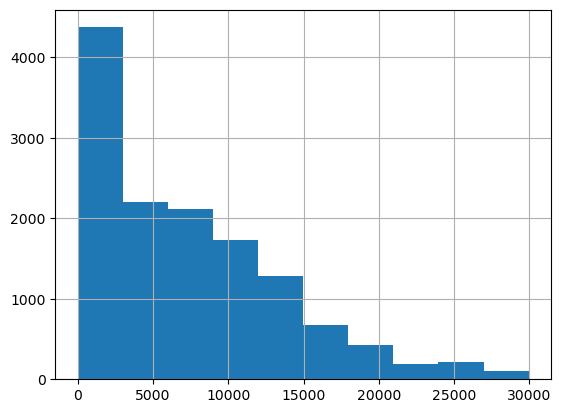

In [13]:
roads_df2[roads_df2['AADT2023'] <= 30000]['AADT2023'].hist(bins=10)

<AxesSubplot: >

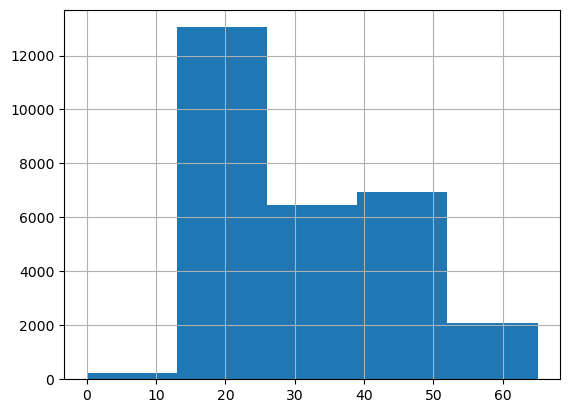

In [14]:
roads_df2['SPEED_LMT'].hist(bins=5)

In [15]:
# adjust data types
roads_df2['AADT2023'] = roads_df2['AADT2023'].fillna(-9999).astype('Int32')
roads_df2['OMS_LANES'] = roads_df2['OMS_LANES'].fillna(-9999).astype('Int32')
roads_df2['LANES_ONE_DIR'] = roads_df2['LANES_ONE_DIR'].fillna(-9999).astype('Float64')
roads_df2.dtypes

UID              string[python]
CARTOCODE        string[python]
NAME             string[python]
SPEED_LMT                 Int32
DOT_AADT                  Int32
DOT_AADTYR       string[python]
DOT_THRULANES             Int32
BIKE_L           string[python]
BIKE_R           string[python]
BIKE_PLN_L       string[python]
BIKE_PLN_R       string[python]
AADT2023                  Int32
OMS_LANES                 Int32
LANES_ONE_DIR           Float64
SHAPE                  geometry
dtype: object

In [16]:
# export
roads_df2.spatial.to_featureclass(location=os.path.join(gdb, 'level_of_stress'), sanitize_columns=False) 

'e:\\Projects\\Bike-App-Create-Features\\Outputs\\scratch2.gdb\\level_of_stress'